# Случайная раскраска области в два цвета, 
# выясняем, протекает ли вода между сторонами прямоугольника

In [1]:
import math
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
# a, b -- целочисленные индексы
# x, y -- вещественные координаты

def Embedd (a, b):
# Эта функция зависит от решетки
    x = a + b / 2
    y = math.sqrt(3) / 2 * b
    return (x, y)

# Наверно, можно на Python как-то культурнее это написать
def EmbeddPoint(P):
    return Embedd(P[0], P[1])

In [3]:
def IsInsideRectangle(x, y): 
# Эта функция зависит от области
    return (x >= 0) & (y >= 0) & (x <= 10) & (y <= 10)

In [9]:
def MakeGraph(amin, amax, bmin, bmax, IsInside):
# Пересечение куска решетки [amin, amax] \times [ bmin, bmax] и фигуры,
# которую описывает функция IsInside
    G = nx.Graph()
    for a in range(amin, amax):
        for b in range(bmin, bmax):
            x, y = Embedd(a, b)
            if IsInside(x, y):
                G.add_node((a, b), pos = (x, y))
    return G
pos = nx.get_node_attributes(G, 'pos')

In [31]:
# Создаем граф дискретизацию прямоугольника [0, 10] \times [0, 10] (как в функции IsInsideRectangle)
# amin, amax, bmin, bmax ставим с запасом

G = MakeGraph(-50, 100, -50,100, IsInsideRectangle)

In [32]:
# Добавляем ребра
for (a, b) in G:
    for (a1, b1) in [(a, b + 1), (a, b - 1), (a + 1, b), (a - 1, b), (a + 1, b - 1), (a - 1, b +1)]:
        if (a1, b1) in G:
            G.add_edge((a, b), (a1, b1), size = 3)

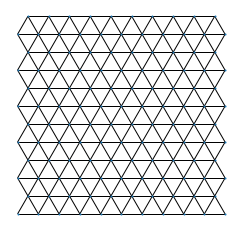

In [33]:
# Рисуем, проверяем, что действительно похоже на квадрат
plt.gca().set_aspect('equal')
nx.draw(G, pos, node_size = 1)
 

In [11]:
nx.dfs_edges((0,0))

<generator object dfs_edges at 0x11beb5c10>

In [24]:
# Раскрашиваем все в серый
# Боковые границы красим в желтый
# Верхнюю и нижнюю границы красим в синий
# Для других областей нужно аккуратнее
colormap = {vertex:'Gray' for vertex in G}
for (a, b) in G:
    if ((a - 1, b) not in G) or ((a + 1, b) not in G): 
        colormap[(a, b)] = 'Yellow'
    else:
        if ((a - 1, b + 1) not in G) or \
        ((a + 1, b - 1) not in G) or \
        ((a, b - 1) not in G) or \
        ((a, b + 1) not in G):
            colormap[(a, b)] = 'Blue'
            


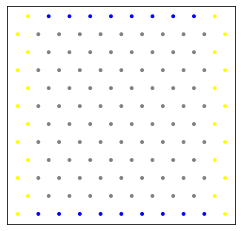

In [13]:
# Проверяем раскраску
plt.gca().set_aspect('equal')
nx.draw_networkx_nodes(G, pos, node_color = [colormap[vertex] for vertex in G], node_size = 8)

In [14]:
# В этом параграфе находим третью вершину маленького равностороннего треугольника

# Тут поворот на 60 градусов против часовой в координатах (a, b)
EdgeDirections = [(1, 0), (0, 1), (-1, 1), (-1, 0), (0, -1), (1, -1)]
Rotations = {EdgeDirections[i] : EdgeDirections[(i + 1) % 6]  for i in range(len(EdgeDirections))}

# Тут собственно нахождение третьей вершины
def ThirdVertex (vertex1, vertex2):
    a1, b1 = vertex1
    a2, b2 = vertex2
    da, db = Rotations[(a2 - a1, b2 - b1)]
    return a1 + da, b1 + db
    

In [16]:
def midpoint(A, B): return ((A[0] + B[0])/2, (A[1] + B[1])/2 )
def centerpoint(A, B, C): return ((A[0] + B[0] + C[0])/3, (A[1] + B[1] + C[1])/3 )


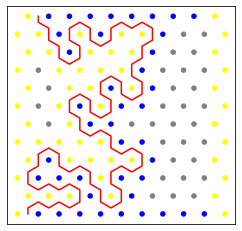

In [25]:
# Тут рисуем интерфейс, начиная с точек Y, B
Y = (0, 0)
B = (1, 0)
Interface = [] #  Красная линия
while True:
    Interface.append(EmbeddPoint(midpoint(Y, B)))
    # Находим третью вершину маленького треугольника
    Z = ThirdVertex(Y,B)
    # Если она вне области -- останавливаемся
    if Z not in G: break      
    Interface.append(EmbeddPoint(centerpoint(B, Y, Z)))  
    # Если она еще не покрашена -- красим случайно
    if colormap[Z] == "Gray" : colormap[Z] = random.choice(["Blue", "Yellow"])
    if colormap[Z] == "Blue" : B = Z
    if colormap[Z] == "Yellow" : Y = Z

plt.gca().set_aspect('equal')
# Рисуем вершины
nx.draw_networkx_nodes(G, pos, node_color = [colormap[vertex] for vertex in G], node_size = 20)

# Рисуем интерфейс
plt.plot([P[0] for P in Interface], [P[1] for P in Interface], color = 'red')

    

# Тут другой сюжет, строим случайное dfs дерево библиотекой NetworkX

In [132]:
# В качестве графа возьмем шестугольную решетку, сделав ее из треугольной
H = G.copy()
nodes = list(H.nodes())
for (a, b) in nodes:
    if (a- b) % 3 == 0 : H.remove_node((a, b))

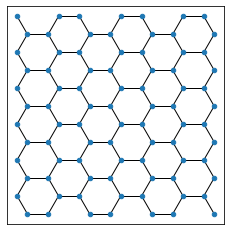

In [133]:
# проверяем, что все правильно
plt.gca().set_aspect('equal')
nx.draw_networkx_nodes(H, pos,  node_size = 20)
nx.draw_networkx_edges(H, pos , width=1)

In [147]:
# Для того, чтобы сделать порядок выбора вершин случаным, создадим ориентированный граф из неориентрованного,
# отличающийся shuffle ребер в каждой вершине
DiH = nx.DiGraph()
for v in H: DiH.add_node(v)

for v in H:
    edges = list(H.edges(v))
    random.shuffle(edges)  #  все ради этой строчки
    for w in edges:
        DiH.add_edge(v, w[1])


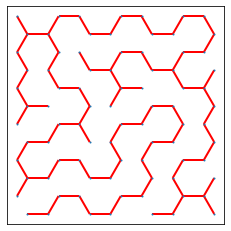

In [148]:
# теперь можно пользоваться благами цивилизации типа nx.dfs_edges, например, так:

plt.gca().set_aspect('equal')
nx.draw_networkx_nodes(DiH, pos,  node_size = 1)
nx.draw_networkx_edges(H, pos, edgelist= list(nx.dfs_edges(DiH, (1,0))), edge_color='r', width=2)